First, we read the data using pandas.

In [1]:
## read data

import pandas as pd
import numpy as np
df = pd.read_csv("Lyrics-Genre-Train.csv", names = ['song','year','artist','genre','lyrics','id'], header=0)

We transform the labels from ['country', 'folk'..etc] to categroical format [[0,0,0,0,1],[1,0,0,0,0]...etc]

In [2]:
## labels to categrorical

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

text_labels = df['genre'].to_numpy()
unique_labels = np.unique(text_labels)
def encode_labels(labels):
    enc = LabelEncoder()
    enc.fit(unique_labels)
    return to_categorical(enc.transform(labels))

y = encode_labels(text_labels)


We read the lyrics from the data frame into a numpy array for ease of use later on.

In [3]:
# read lyrics

lyrics = df['lyrics'].astype('U').to_numpy()

Here we begin our first approach. I tried using a Hashing Vectorizer(because Count Vectorizer wouldn't fit inside memory, taking into account the number of words). I used unigrams and bigrams and 2^13 features.

In [4]:
## encode with hashing vectorizer
from sklearn.feature_extraction.text import HashingVectorizer
n_features = 2**13

vectorizer = HashingVectorizer(n_features=n_features, ngram_range=(1,2), alternate_sign=False)
X = vectorizer.fit_transform(lyrics).toarray()

Here we split the data into train(80%) and validation(20%). As a mention, I used a non-seeded train_validation split(eg. it's different every time the code runs).

In [5]:
## train validation split
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X,y, train_size=0.80)

We test the encoding using a NN with 3 fully contected layers.
Optimizer: Adam
Loss: Categorical Crossentropy

In [6]:
## model

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from keras.layers import Dense, Dropout

def build_model():
    model = Sequential()
    model.add(Dense(80, activation='relu', input_dim=n_features))
    model.add(Dropout(0.4))
    model.add(Dense(40, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    return model

model = build_model()
model.summary()

model.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"],
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 80)                655440    
_________________________________________________________________
dropout (Dropout)            (None, 80)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                3240      
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                820       
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2

In [7]:
## train model

history = model.fit(X_train, y_train, validation_data=(X_validation,y_validation), epochs=15, batch_size=64, shuffle=True)

Epoch 1/15
232/232 [==============================] - 1s 3ms/step - loss: 2.1753 - accuracy: 0.2130 - val_loss: 2.0155 - val_accuracy: 0.2806
Epoch 2/15
232/232 [==============================] - 1s 3ms/step - loss: 1.9495 - accuracy: 0.3072 - val_loss: 1.8856 - val_accuracy: 0.3351
Epoch 3/15
232/232 [==============================] - 1s 3ms/step - loss: 1.7730 - accuracy: 0.3652 - val_loss: 1.8344 - val_accuracy: 0.3586
Epoch 4/15
232/232 [==============================] - 1s 3ms/step - loss: 1.6213 - accuracy: 0.4199 - val_loss: 1.8504 - val_accuracy: 0.3446
Epoch 5/15
232/232 [==============================] - 1s 3ms/step - loss: 1.4810 - accuracy: 0.4715 - val_loss: 1.9180 - val_accuracy: 0.3481
Epoch 6/15
232/232 [==============================] - 1s 3ms/step - loss: 1.3232 - accuracy: 0.5261 - val_loss: 2.0254 - val_accuracy: 0.3519
Epoch 7/15
232/232 [==============================] - 1s 3ms/step - loss: 1.1819 - accuracy: 0.5821 - val_loss: 2.1294 - val_accuracy: 0.3497
Epoch 

Here we print the measurements for this approach.

accuracy: 34.567
labels: ['Country' 'Electronic' 'Folk' 'Hip-Hop' 'Indie' 'Jazz' 'Metal' 'Pop'
 'R&B' 'Rock']
confusion matrix:
 [[125   6  20   9  19  58   7  48  11  55]
 [ 19  54  13  25  26  20  32  57  16  73]
 [ 29  12  41   2  10  17  28  17  10  45]
 [ 10   5   5 327   9   7  18  29  25  15]
 [ 23  20  18   2  37  20  17  27  10  72]
 [ 68   9  16  10  23  87   8  40  15  40]
 [  8  25   8  12  10   4 228  13   3  62]
 [ 34  31  19  37  31  34  26 134  38  87]
 [ 28  17   7  12  16  51  16  43  31  56]
 [ 69  40  23  24  51  54  68  89  32 216]]


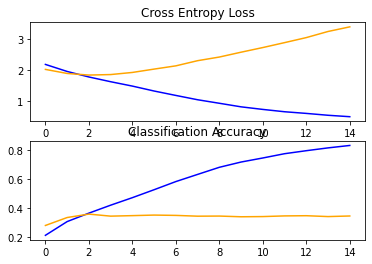

In [8]:
## print acc graphs and confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def summarize_diagnostics(history):
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')


plt.show()

_, acc = model.evaluate(X_validation, y_validation, verbose=0)
print('accuracy: %.3f' % (acc * 100.0))

predictions = np.argmax(model.predict(X_validation), axis=1)
ground_truth = np.argmax(y_validation, axis=1)
matrix = confusion_matrix(ground_truth, predictions)
print('labels:',unique_labels)
print('confusion matrix:\n',matrix)

summarize_diagnostics(history)

We have an accuracy of 34.5% on validation data. We can see that, according to the confusion matrix, hip-hop is the most accurate genre. We'll see later why. Rock, Pop, Metal and Country are also decently accurate. The rest are completly random.

In the next cell, I tried looking at the lyrics, in the hope of finding a good metric to classify upon.

In [10]:
number = 0
song = lyrics[number]
print(text_labels[number])
for i in song.split('\n'):
    print(i)

Metal
I am a night in to the darkness, only soul lost with me, I walk throught the
night in to the forest and everything stays behind me, i`m waiting for another chance...it
calls.
I capture my eyes, I wait for the end, I see the holograms of today, only soul with me I
carry my shadow, and it call`s my name...my name.
I see the light, my mind can`t touch it, emperors name and the final thoughts, hearing
whispering from my soul, i`m so cold inside but still it`s a truth...whispering inside of
me.
I touch my eyes, i`m dreaming for end, and enchanting woods is only a dream, I feel the
sun my eyes will burn, for my soul I see anything.


These lyrics use a lot of 'cold' words: cold, darkness, shadow, night. This gave me the idea of sentiment analysis. Below I try just that.

In [11]:
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer

negative = []
neutral = []
positive = []
compound = []
sentiments = []

sid = SentimentIntensityAnalyzer()

for i in df.index:
    scores = sid.polarity_scores(df['lyrics'].iloc[i])
    negative.append(scores['neg'])
    neutral.append(scores['neu'])
    positive.append(scores['pos'])
    compound.append(scores['compound'])
    sentiments.append([scores['neg'],scores['neu'],scores['pos'],scores['compound']])

df['negative'] = negative
df['neutral'] = neutral
df['positive'] = positive
df['compound'] = compound
df.head()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\anama\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,song,year,artist,genre,lyrics,id,negative,neutral,positive,compound
0,forest-enthroned,2007,catamenia,Metal,"I am a night in to the darkness, only soul los...",18096,0.028,0.950,0.022,0.0900
1,superhero,2010,aaron-smith,Hip-Hop,"Yeah\nSometimes, i just wanna fly away.\nThey ...",22724,0.038,0.713,0.250,0.9990
2,chicago-now,2007,fall,Metal,Do you work hard?\nDo you work hard?\nYou don'...,24760,0.119,0.855,0.026,-0.6517
3,the-secret,2007,geto-boys,Hip-Hop,You know what? I'm destined to be the last man...,24176,0.103,0.813,0.084,-0.9021
4,be-the-lake,2011,brad-paisley,Country,There ain't nothing that I would rather see\nT...,17260,0.068,0.727,0.205,0.9845


As we can see, this might be problematic, in the sense that, according to this analyzer, most of the lyrics are mostly neutral, having an average neutral score of 76%.

In [16]:
print(sum(df['neutral'])/len(df['neutral']))

0.7635765678172062


In [17]:
#normalize the data (-1,1) -> (0,1)
feature_vector = (np.array(sentiments)+1)/2

Split train, validation, build a similar model and train.

In [20]:
X_train, X_validation, y_train, y_validation = train_test_split(feature_vector,y, train_size=0.80)

In [21]:
def build_model():
    model = Sequential()
    model.add(Dense(256, activation='relu', input_dim=4))
    model.add(Dropout(0.1))
    
    model.add(Dense(64, activation='relu'))
    
    model.add(Dropout(0.1))
    model.add(Dense(10, activation='softmax'))
    return model

model = build_model()


model.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"],
)

In [22]:
## train model

history = model.fit(X_train, y_train, validation_data=(X_validation,y_validation), epochs=100, batch_size=64, shuffle=True, verbose=0)

accuracy: 25.574
labels: ['Country' 'Electronic' 'Folk' 'Hip-Hop' 'Indie' 'Jazz' 'Metal' 'Pop'
 'R&B' 'Rock']
confusion matrix:
 [[  0   0   0  14   0  67  24  53   0 217]
 [  0   0   0  36   0  33  31  49   0 163]
 [  0   0   0  22   0  30  15  35   0 119]
 [  0   0   0 231   0  14  22  91   0 104]
 [  0   0   0  29   0  15  20  26   0 129]
 [  0   0   0  14   0  62  21  47   0 161]
 [  0   0   0  47   0   5 144  12   0 150]
 [  0   0   0  56   0  71  29 133   0 265]
 [  0   0   0  23   0  34  24  55   0  94]
 [  0   0   0  60   0  52  87  91   0 377]]


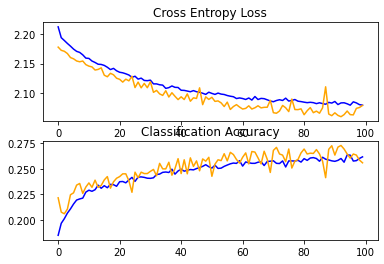

In [23]:
## print acc graphs and confusion matrix

plt.show()

_, acc = model.evaluate(X_validation, y_validation, verbose=0)
print('accuracy: %.3f' % (acc * 100.0))

predictions = np.argmax(model.predict(X_validation), axis=1)
ground_truth = np.argmax(y_validation, axis=1)
matrix = confusion_matrix(ground_truth, predictions)
print('labels:',unique_labels)
print('confusion matrix:\n',matrix)

summarize_diagnostics(history)

The accuracy here is 25.5%. According to this confusion matrix, Country, Electronic, Folk, Indie and R&B have no sentiments at all. Sentriments prove  to be a bad feature for this, as genres are not mono-sentimental and thus cannot be differentiated this way.

Next, I try to look at the data some more. Specifically, word count.

In [24]:
import string
sentences = [i.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation))) for i in lyrics]
tokens = [nltk.word_tokenize(i) for i in sentences]

In [25]:
import statistics
lengths = [len(i) for i in tokens]
print(min(lengths),sum(lengths)/len(lengths),statistics.median(lengths),max(lengths))

8 259.65910441311513 212 1952


Shortest song is 8 words, average number of words is 260, the median is 212 and the longst song has 1952 words.

In [20]:
df['lengths'] = lengths
number = 2000
country = np.zeros(number)
electronic = np.zeros(number)
folk = np.zeros(number)
hiphop = np.zeros(number)
indie = np.zeros(number)
jazz = np.zeros(number)
metal = np.zeros(number)
pop = np.zeros(number)
rnb = np.zeros(number)
rock = np.zeros(number)
for i in df.index:
    if(df['genre'].iloc[i]=='Country'):
        country[df['lengths'].iloc[i]]+=1
    if(df['genre'].iloc[i]=='Electronic'):
        electronic[df['lengths'].iloc[i]]+=1
    if(df['genre'].iloc[i]=='Folk'):
        folk[df['lengths'].iloc[i]]+=1
    if(df['genre'].iloc[i]=='Hip-Hop'):
        hiphop[df['lengths'].iloc[i]]+=1
    if(df['genre'].iloc[i]=='Indie'):
        indie[df['lengths'].iloc[i]]+=1
    if(df['genre'].iloc[i]=='Jazz'):
        jazz[df['lengths'].iloc[i]]+=1
    if(df['genre'].iloc[i]=='Metal'):
        metal[df['lengths'].iloc[i]]+=1
    if(df['genre'].iloc[i]=='Pop'):
        pop[df['lengths'].iloc[i]]+=1
    if(df['genre'].iloc[i]=='R&B'):
        rnb[df['lengths'].iloc[i]]+=1
    if(df['genre'].iloc[i]=='Rock'):
        rock[df['lengths'].iloc[i]]+=1

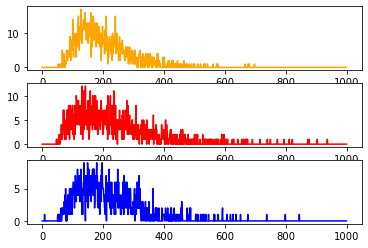

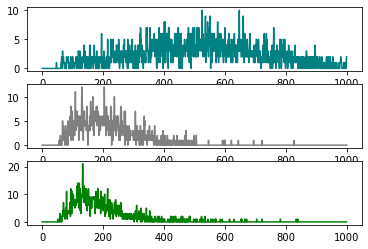

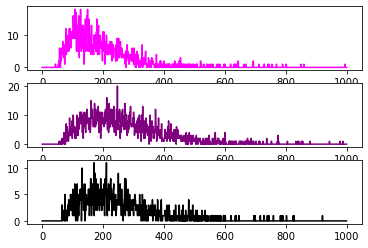

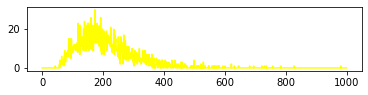

In [21]:
plt.show()
plt.subplot(311)
plt.plot(country[0:1000], color='orange')
plt.subplot(312)
plt.plot(electronic[0:1000], color='red')
plt.subplot(313)
plt.plot(folk[0:1000], color ='blue')
plt.show()
plt.subplot(311)
plt.plot(hiphop[0:1000], color ='teal')
plt.subplot(312)
plt.plot(indie[0:1000], color ='gray')
plt.subplot(313)
plt.plot(jazz[0:1000], color ='green')
plt.show()
plt.subplot(311)
plt.plot(metal[0:1000], color ='magenta')
plt.subplot(312)
plt.plot(pop[0:1000], color ='purple')
plt.subplot(313)
plt.plot(rnb[0:1000], color ='black')
plt.show()
plt.subplot(311)
plt.plot(rock[0:1000], color ='yellow')


These plots represent the number of songs on the Y axis and the number of words per song on the X axis. Now we get why hip-hop had such high accuracy. It contains way more words(400 on average) than the other genres. On the other hand, all the other genres seem very similar in terms of word count.

Next approach I will try will be an word2vec embbedding using a bi-LSTM

In [26]:
MAX_SEQUENCE_LENGTH = 1200
MAX_VOCAB_SIZE = 40000
EMBEDDING_DIM = 200

In [27]:
word2vec = {}
with open('Glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec

Tokenize the lyrics from 1 to MAX_VOCAB_SIZE

In [31]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(lyrics)
seq = tokenizer.texts_to_sequences(lyrics)
tokidx = tokenizer.word_index
print(tokidx)
# 0 is used for padding in keras

{'the': 1, 'i': 2, 'you': 3, 'and': 4, 'to': 5, 'a': 6, 'me': 7, 'my': 8, 'in': 9, 'it': 10, 'of': 11, 'your': 12, 'that': 13, 'on': 14, "i'm": 15, 'is': 16, 'all': 17, 'for': 18, 'be': 19, 'we': 20, 'so': 21, 'with': 22, 'love': 23, 'like': 24, 'but': 25, "don't": 26, 'know': 27, 'this': 28, 'up': 29, 'just': 30, 'no': 31, "it's": 32, 'when': 33, 'what': 34, 'do': 35, 'get': 36, 'can': 37, 'got': 38, 'now': 39, 'oh': 40, 'if': 41, 'out': 42, 'go': 43, 'they': 44, 'was': 45, 'one': 46, 'down': 47, 'see': 48, 'time': 49, 'are': 50, 'never': 51, 'will': 52, "you're": 53, 'from': 54, 'not': 55, 'have': 56, 'she': 57, "can't": 58, 'want': 59, 'baby': 60, 'come': 61, 'at': 62, 'say': 63, 'way': 64, 'back': 65, 'make': 66, 'let': 67, 'as': 68, 'her': 69, 'yeah': 70, 'he': 71, "i'll": 72, 'take': 73, 'how': 74, 'there': 75, 'life': 76, 'feel': 77, 'right': 78, 'by': 79, 'here': 80, 'away': 81, 'gonna': 82, 'heart': 83, 'need': 84, "ain't": 85, 'been': 86, 'more': 87, "i've": 88, 'where': 89, 

We pad the sequences so that the matrix is not jagged(this is a keras requirement).

In [32]:
from keras.preprocessing.sequence import pad_sequences
data = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
print(data.shape)

(18513, 1200)


In [33]:
X_train, X_validation, y_train, y_validation = train_test_split(data, y, train_size=0.8)

We create the embedding matrix for the embedding layer.

In [37]:
num_words = min(MAX_VOCAB_SIZE, len(tokidx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
print(embedding_matrix.shape)
for word, i in tokidx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector

(40000, 200)


Here we create a deep learning model with the embedding layer,a bidirectional LSTM, a global max pool and a softmax layer. Same optimizer and loss function.

In [47]:
from keras.layers import Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout

embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)
def build_model():
    model = Sequential()
    model.add(Input(shape=(MAX_SEQUENCE_LENGTH,)))
    embedding_layer = Embedding(
        num_words,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False
    )
    model.add(embedding_layer)
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(0.4))
    model.add(Dense(10,activation='softmax'))
    
    return model

model = build_model()

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy'],
)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 1200, 200)         8000000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 1200, 128)         135680    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1290      
Total params: 8,136,970
Trainable params: 136,970
Non-trainable params: 8,000,000
_________________________________________________________________


In [51]:
history = model.fit(X_train, y_train, validation_data=(X_validation,y_validation), epochs=13, batch_size=64, shuffle=True, verbose=1)

Epoch 1/13
232/232 [==============================] - 21s 90ms/step - loss: 1.4080 - accuracy: 0.5172 - val_loss: 1.7380 - val_accuracy: 0.3945
Epoch 2/13
232/232 [==============================] - 21s 91ms/step - loss: 1.3759 - accuracy: 0.5269 - val_loss: 1.7336 - val_accuracy: 0.4018
Epoch 3/13
232/232 [==============================] - 21s 91ms/step - loss: 1.3462 - accuracy: 0.5378 - val_loss: 1.7308 - val_accuracy: 0.3986
Epoch 4/13
232/232 [==============================] - 21s 91ms/step - loss: 1.3324 - accuracy: 0.5484 - val_loss: 1.7422 - val_accuracy: 0.4024
Epoch 5/13
232/232 [==============================] - 21s 91ms/step - loss: 1.3051 - accuracy: 0.5528 - val_loss: 1.7486 - val_accuracy: 0.3989
Epoch 6/13
232/232 [==============================] - 21s 91ms/step - loss: 1.2784 - accuracy: 0.5633 - val_loss: 1.7539 - val_accuracy: 0.4037
Epoch 7/13
232/232 [==============================] - 21s 91ms/step - loss: 1.2521 - accuracy: 0.5771 - val_loss: 1.7471 - val_accuracy:

accuracy: 39.238
labels: ['Country' 'Electronic' 'Folk' 'Hip-Hop' 'Indie' 'Jazz' 'Metal' 'Pop'
 'R&B' 'Rock']
confusion matrix:
 [[192   1  22   1   4  53   2  18   7  64]
 [ 18  29   9  21   8  25  18  70   5 138]
 [ 37   1  67   2   6  23  13  19   1  75]
 [  2   8   2 287   1   3   8  37   9  45]
 [ 23  11  13   1  14  20   7  19   2 133]
 [ 54   6  12   5   4 127   4  27   5  59]
 [  7   5   6  14   2   3 241   7   0 106]
 [ 57  16  15  38  15  45  12 121  19 188]
 [ 26   6   1  12   2  35  10  42  26  93]
 [ 80  13  18   8  19  46  42  49  12 349]]


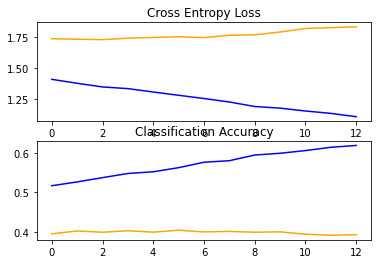

In [52]:
## print acc graphs and confusion matrix

plt.show()

_, acc = model.evaluate(X_validation, y_validation, verbose=0)
print('accuracy: %.3f' % (acc * 100.0))

predictions = np.argmax(model.predict(X_validation), axis=1)
ground_truth = np.argmax(y_validation, axis=1)
matrix = confusion_matrix(ground_truth, predictions)
print('labels:',unique_labels)
print('confusion matrix:\n',matrix)

summarize_diagnostics(history)

Here we get an accuracy of 40%. Thus far, this is the best model. This is due to the word2vec embedding and the LSTM. Even so we notice only a 6% increase in accuracy.

Now we use this model on the test data. First we take the test data through the same preprocessing.

In [62]:
df_test = pd.read_csv("Lyrics-Genre-Test-GroundTruth.csv", names = ['song','year','artist','genre','lyrics','id'], header=0)
text_labels = df_test['genre'].to_numpy()
unique_labels = np.unique(text_labels)
def encode_labels(labels):
    enc = LabelEncoder()
    enc.fit(unique_labels)
    return to_categorical(enc.transform(labels))

y_test = encode_labels(text_labels)
lyrics_test = df_test['lyrics'].astype('U').to_numpy()
seq = tokenizer.texts_to_sequences(lyrics_test)
X_test = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)


accuracy: 41.928
labels: ['Country' 'Electronic' 'Folk' 'Hip-Hop' 'Indie' 'Jazz' 'Metal' 'Pop'
 'R&B' 'Rock']
confusion matrix:
 [[457   4  30   1  22  90   8  34   7 157]
 [ 23  69  20  33  19  46  43 110   7 290]
 [ 67  19 138   3   8  48  23  24   2 163]
 [ 14  16   3 744   5  22  11  52  11  82]
 [ 54  13  28   8  44  45  13  31   8 266]
 [111   7  32  11   6 266   9  74  16 128]
 [ 12  11  11  19   9   7 473  19   3 246]
 [108  39  33  55  22 123  29 288  47 366]
 [ 69   5   6  19   2  53  16  80  74 186]
 [150  28  48  16  45  97  93 127  32 774]]


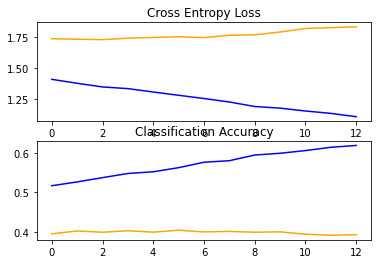

In [63]:
plt.show()

_, acc = model.evaluate(X_test, y_test, verbose=0)
print('accuracy: %.3f' % (acc * 100.0))

predictions = np.argmax(model.predict(X_test), axis=1)
ground_truth = np.argmax(y_test, axis=1)
matrix = confusion_matrix(ground_truth, predictions)
print('labels:',unique_labels)
print('confusion matrix:\n',matrix)

summarize_diagnostics(history)

We get a test accuracy of 42% which is good, compared to the validation accuracy of our first model.